In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats 
import os
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
%matplotlib inline

<font size=3>
Importing Datasets

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
geo = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category = pd.read_csv('product_category_name_translation.csv')


<font size=3>
Merging Datasets

In [3]:
df_train = orders.merge(items, on='order_id', how='left')
df_train = df_train.merge(payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(reviews, on='order_id', how='outer')
df_train = df_train.merge(products, on='product_id', how='outer')
df_train = df_train.merge(customers, on='customer_id', how='outer')
df_train = df_train.merge(sellers, on='seller_id', how='outer')
print(df_train.shape)

(119143, 39)


**Starting Data Exploration**

**Product orders purchased based on the states**

<AxesSubplot: xlabel='geolocation_state', ylabel='count'>

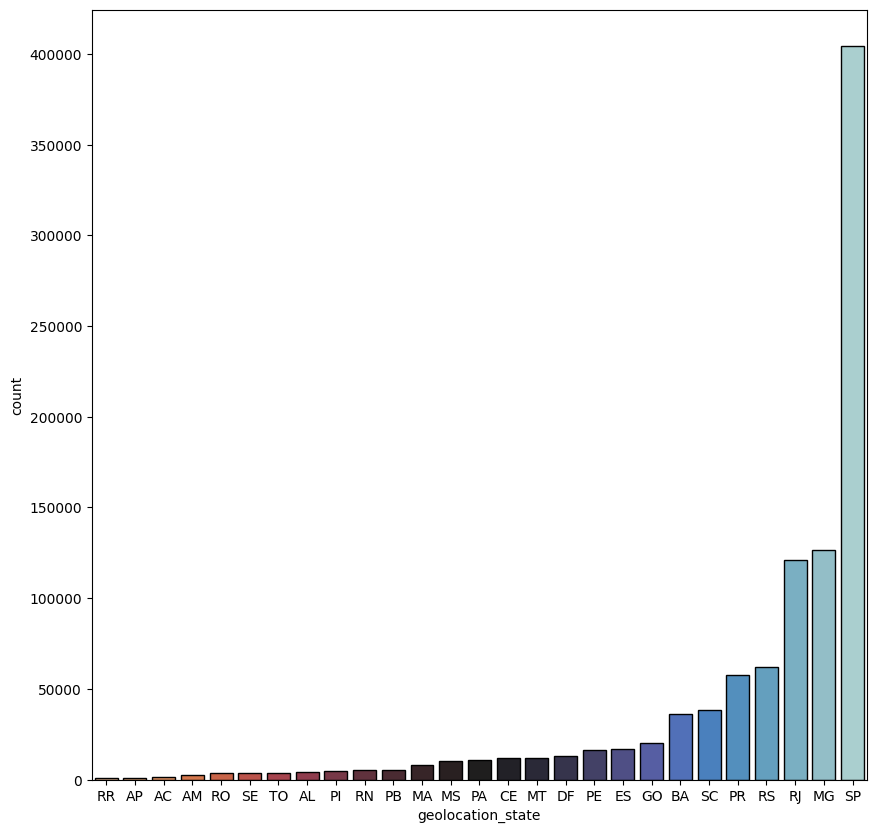

In [4]:
plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=geo, 
              order=geo['geolocation_state'].value_counts().sort_values().index, 
              palette='icefire_r')

<font size=3>
Checking null values from orders

In [5]:
df_train.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542


- Missing values' proportion is around 3%, Null Values from customer date feature will be filled with forward-fill method. This method, propagate the previous value forward

In [6]:
df_train['order_delivered_customer_date']= df_train['order_delivered_customer_date'].fillna(method='ffill')
df_train['order_delivered_customer_date'].isnull().sum()

0

<font size=3>
Delivered time and Estimate time features will be created.

In [27]:
df_train['delivered_time']=pd.to_datetime(df_train['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
df_train['estimate_time']=pd.to_datetime(df_train['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

<font size=3>
Finding different days of delivered and estimated times

In [30]:
df_train['diff_days']= df_train['delivered_time']-df_train['estimate_time']
df_train['diff_days']= df_train['diff_days'].dt.days

<font size=3>
Setting up states

In [9]:
# Seting regions
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

df_train.loc[df_train['customer_state'].isin(sudeste), 'cust_Region'] = 'Southeast'
df_train.loc[df_train['customer_state'].isin(nordeste), 'cust_Region'] = 'Northeast'
df_train.loc[df_train['customer_state'].isin(norte), 'cust_Region'] = 'North'
df_train.loc[df_train['customer_state'].isin(centro_oeste), 'cust_Region'] = 'Midwest'
df_train.loc[df_train['customer_state'].isin(sul), 'cust_Region'] = 'South'


**Freight mean per State**

In [10]:
def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

cross_heatmap(df_train[df_train['price'] != -1], ['seller_state', 'cust_Region'], 
              values=df_train[df_train['price'] != -1]['freight_value'], aggfunc='mean')

cust_Region,Midwest,North,Northeast,South,Southeast
seller_state,,,,,
AC,nan,nan,nan,nan,32.840000
AM,nan,nan,28.255000,nan,25.290000
BA,29.977381,46.290476,22.736355,39.643671,33.618110
CE,65.456667,85.614000,29.744054,51.445556,47.044130
DF,13.070164,58.371935,27.607364,27.096786,19.636728
ES,36.895833,68.896250,36.664464,39.894510,28.461445
GO,14.686705,26.595909,33.369841,30.535870,24.201088
MA,27.150192,28.859000,19.453333,42.660652,31.880362
MG,26.861624,41.899053,33.968349,28.904398,21.153626


- SP sellers have a lowest mean of freights to all regions.
- CE sellers have high mean value
- We can note that the sellers from southeast could have a better competitive advantage.

**Delivery truck operation**

In [11]:
olist = pd.read_csv("df_train_merged.csv", index_col=0, parse_dates=['order_purchase_timestamp', 
                    'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date', 
                    'review_creation_date', 'review_answer_timestamp'])

olist['total_value'] = olist['price'].add(olist['freight_value'])

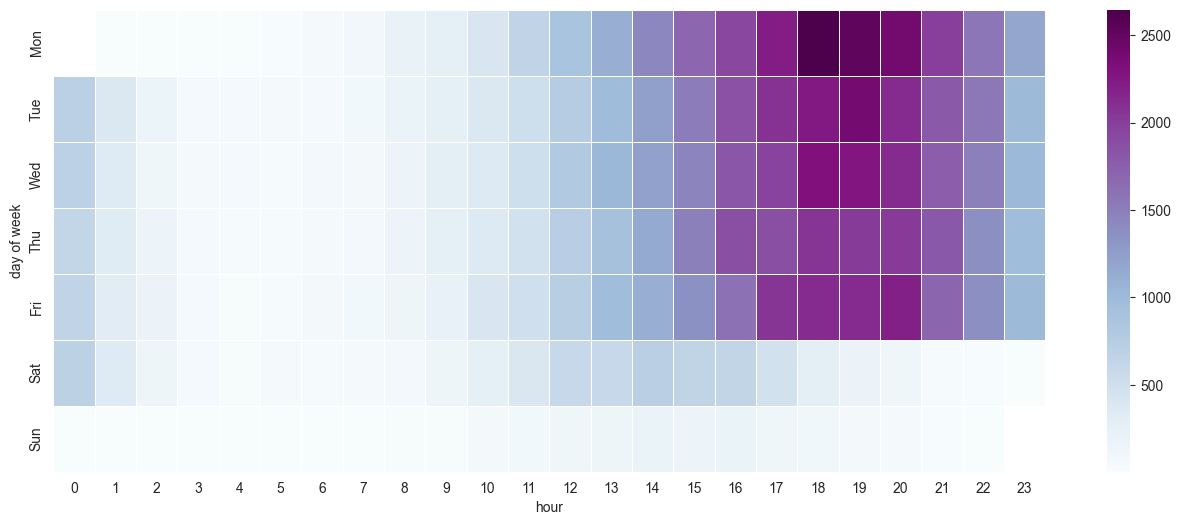

In [26]:
dweekday = olist['order_delivered_customer_date'].dt.weekday
dhour = olist['order_delivered_customer_date'].dt.hour
dprice = olist['total_value']
delivery = pd.DataFrame({'day of week': dweekday, 'hour': dhour, 'price': dprice})
delivery['day of week'] = delivery['day of week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
delivery_count = delivery.groupby(['day of week', 'hour']).count()['price'].unstack()
plt.figure(figsize=(16,6))
sns.heatmap(delivery_count.reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), 
            cmap="BuPu", linewidths=0.5)

delivery.to_csv(r'D:\Data Portfolio\SalesAnalytics-OlistBR\delivery.csv')

- Weekdays from 3-9pm are heaviest postal delivery truck operators

**Frequency of customers to shop online**

<AxesSubplot: xlabel='hour', ylabel='day of week'>

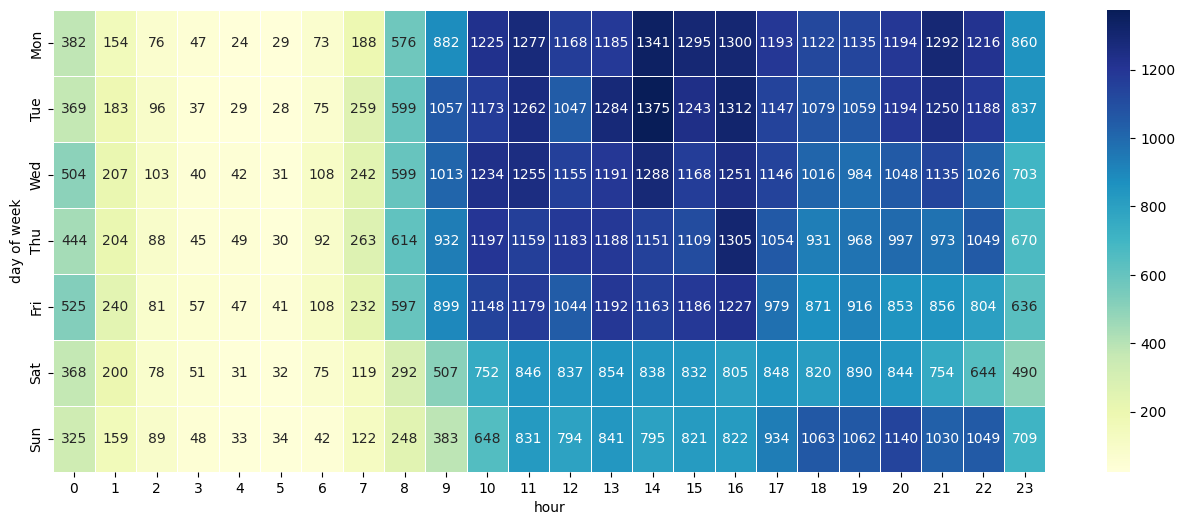

In [13]:
pweekday = olist['order_purchase_timestamp'].dt.weekday
phour = olist['order_purchase_timestamp'].dt.hour
pprice = olist['total_value']
purchase = pd.DataFrame({'day of week': pweekday, 'hour': phour, 'price': pprice})
purchase['day of week'] = purchase['day of week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
purchase_count = purchase.groupby(['day of week', 'hour']).count()['price'].unstack()
plt.figure(figsize=(16,6))
sns.heatmap(purchase_count.reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), 
            cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)

- Customers tend to shop online on weekdays from 10am to 4pm. There are sudden peaks around 8-9pm too (Mon-Thu) and intuitively, on sunday nights (5-9pm), online buyers restart their shopping habbits from relatively low Saturday

**Ordered Items**

In [14]:
df_train['ord_new'] = df_train['order_item_id'].copy()

df_train.loc[df_train['order_item_id'].isin([7,8,9,10]), 'ord_new'] = '7 to 10'
df_train.loc[(df_train['order_item_id'] > 10), 'ord_new'] = '10 to 20'

(0.0, 114009.50000000001)

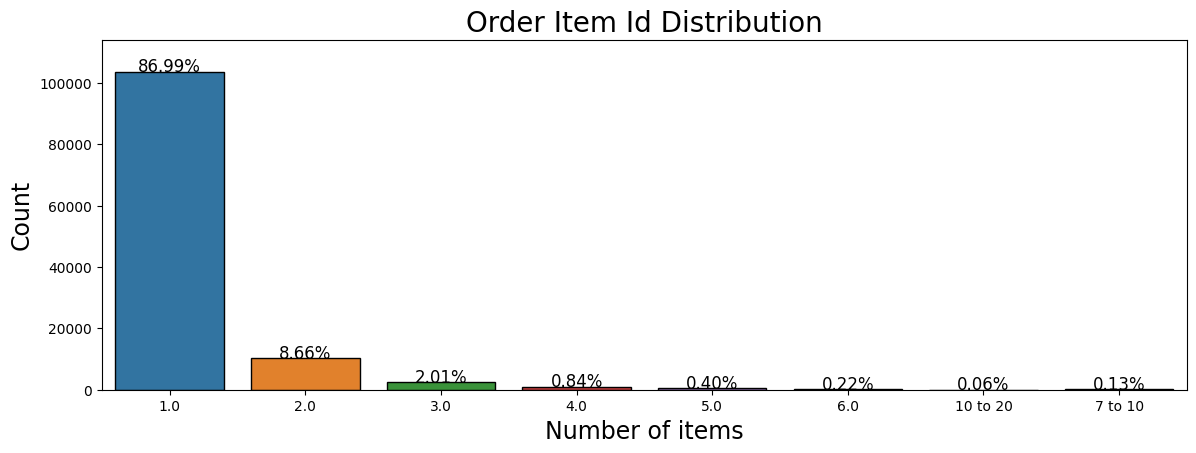

In [15]:
plt.figure(figsize=(14,10))


plt.subplot(211)
g = sns.countplot(x='ord_new', data=df_train)
g.set_title("Order Item Id Distribution", fontsize=20)
g.set_xlabel("Number of items", fontsize=17)
g.set_ylabel("Count", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    total = len(df_train)
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

- 86.99% of items ordered are of only one item

**Top 10 Products**

In [16]:
df_train['product_id_shorten']=df_train['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

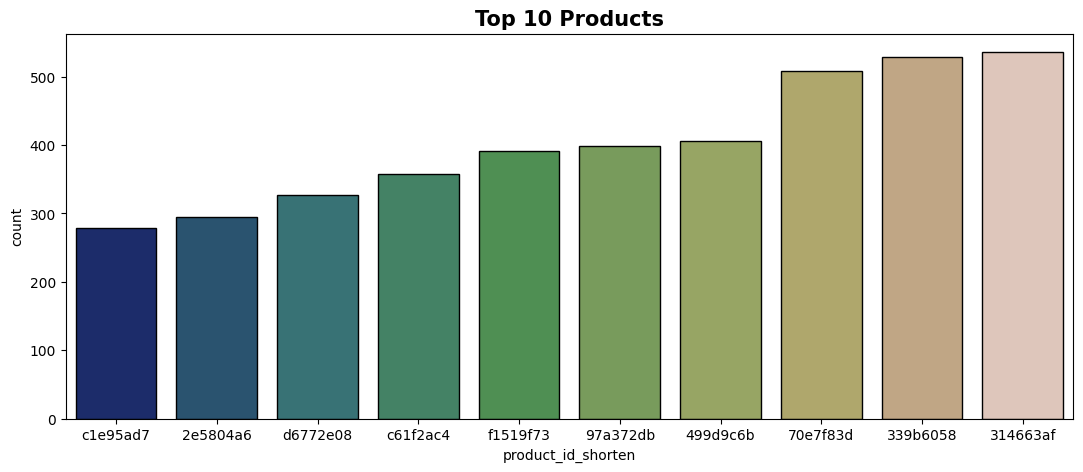

In [17]:
plt.figure(figsize=(13,5))
sns.countplot(x='product_id_shorten', data=df_train, palette='gist_earth',
             order=df_train['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

**Price per purchase Distribution**

(0.0, 600.0)

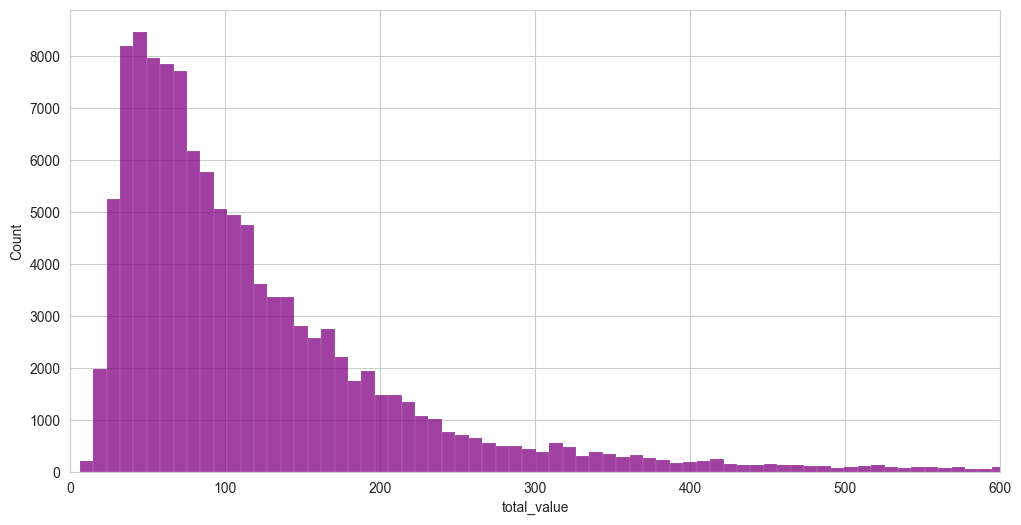

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))
sns.histplot(olist['total_value'], bins=800 ,kde=False, color='purple')
plt.xlim([0, 600])

- Most of the times, people buy cheaply priced goods on olist

**Top Category**

In [19]:
df_train.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

product_category_name
cama_mesa_banho           11988
beleza_saude              10032
esporte_lazer              9004
moveis_decoracao           8832
informatica_acessorios     8150
utilidades_domesticas      7380
relogios_presentes         6213
telefonia                  4726
ferramentas_jardim         4590
automotivo                 4400
Name: product_id_shorten, dtype: int64

- According to the table, bed_table_bath orders have the highest one.

**Orders per category**

In [20]:
group_category= df_train.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

product_id_shorten  product_category_name 
314663af            moveis_decoracao          536
339b6058            cama_mesa_banho           528
70e7f83d            ferramentas_jardim        508
499d9c6b            ferramentas_jardim        406
97a372db            ferramentas_jardim        398
f1519f73            ferramentas_jardim        391
c61f2ac4            informatica_acessorios    357
d6772e08            relogios_presentes        327
2e5804a6            beleza_saude              295
c1e95ad7            informatica_acessorios    278
Name: product_id_shorten, dtype: int64

- Despite the top product category of bed_table_bath, the top ordered product's category is a home decoration.

**Top sellers**

Text(0.5, 1.0, 'Top 10 Seller')

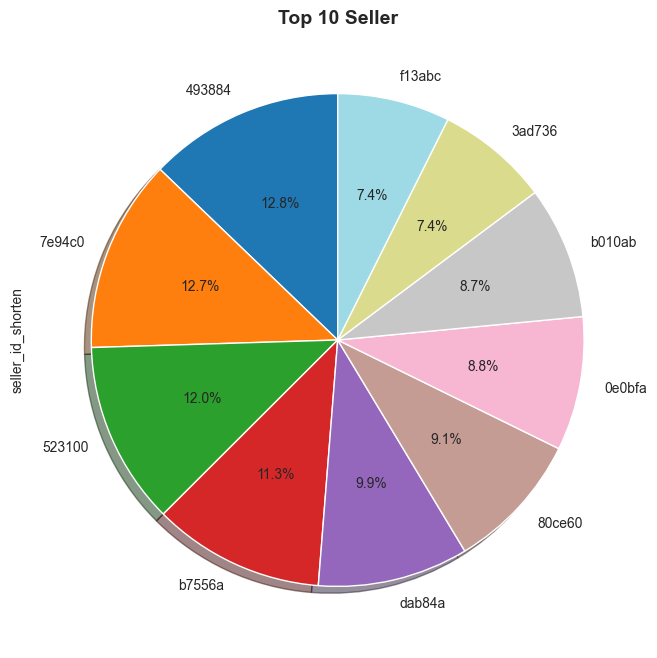

In [21]:
df_train['seller_id_shorten']=df_train['seller_id'].str[-6:]

plt.figure(figsize=(15,8))
df_train['seller_id_shorten'].value_counts()[:10].plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90, cmap='tab20')
plt.title("Top 10 Seller",size=14, weight='bold')

**Reviews Score**

In [22]:
round(pd.crosstab(df_train['order_item_id'], df_train['review_score'], normalize='index') *100,2)[:12].T

order_item_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
review_score,,,,,,,,,,,,
1.0,11.09,21.97,25.60,28.78,29.89,32.95,41.67,41.67,50.00,52.0,47.06,50.00
2.0,3.16,5.73,6.19,6.33,6.02,3.88,3.33,0.00,0.00,0.0,0.00,0.00
3.0,8.25,9.31,9.28,8.98,9.03,10.08,13.33,13.89,14.29,16.0,17.65,8.33
4.0,19.42,16.08,15.85,15.51,16.13,15.89,15.00,19.44,17.86,12.0,17.65,16.67
5.0,58.08,46.91,43.07,40.41,38.92,37.21,26.67,25.00,17.86,20.0,17.65,25.00


- We can note that orders with few quantities have highest review score's.

**Most used Payment Type**

In [23]:
df_train['price_log'] = np.log(df_train['price'] + 1.5)

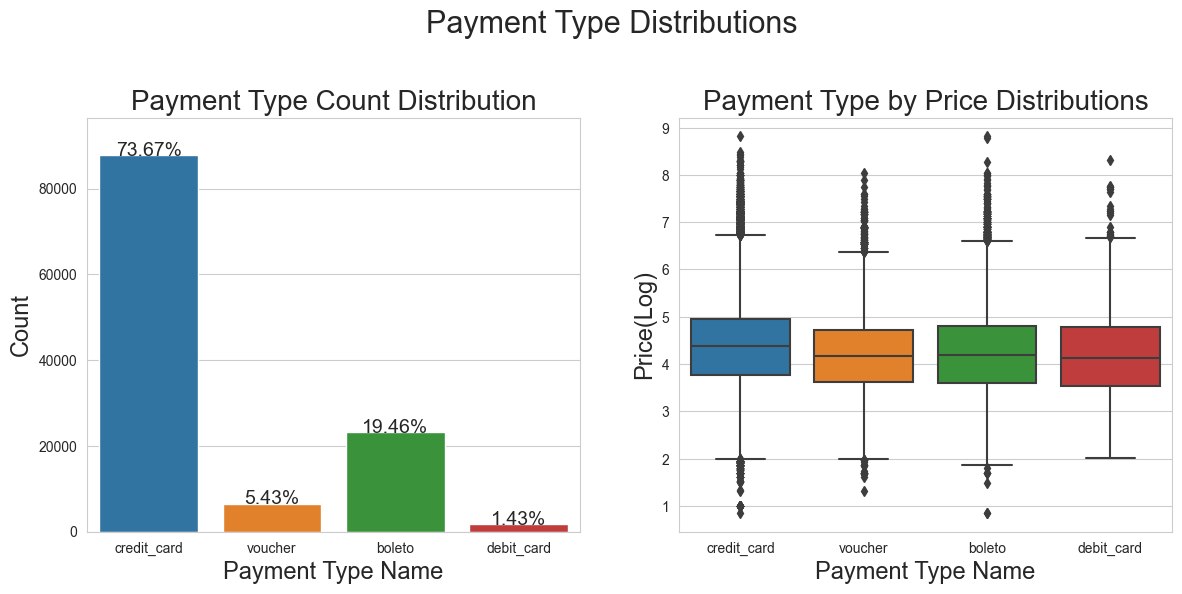

In [24]:
total = len(df_train)

plt.figure(figsize=(14,6))

plt.suptitle('Payment Type Distributions', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=df_train[df_train['payment_type'] != 'not_defined'])
g.set_title("Payment Type Count Distribution", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type', y='price_log', data=df_train[df_train['payment_type'] != 'not_defined'])
g.set_title("Payment Type by Price Distributions", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Price(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

- More than 73.5% of all sales are the Payment type is Credit Card.
- Second most common Payment Type is "boleto"(invoice) with almost 19.5%.

Exporting merged dataset to use on PowerBI

In [25]:
df_train.to_csv(r'D:\Data Portfolio\SalesAnalytics-OlistBR\df_train_merged.csv', index=False)